In [1]:
import lilio
import urllib
import xarray as xr
import dianna
import numpy as np
import pandas as pd

from numba.core.errors import NumbaDeprecationWarning
import warnings
# silence the Numba deprecation warnings in shap
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

In [2]:
# create custom calendar based on the time of interest
calendar = lilio.Calendar(anchor="08-01", allow_overlap=True)
# add target periods
calendar.add_intervals("target", length="30d")
# add precursor periods
periods_of_interest = 8
calendar.add_intervals("precursor", "1M", gap="1M", n=periods_of_interest)

In [3]:
def load_data(url, field, var):
    # Download and load dataset
    url_field = url + field
    urllib.request.urlretrieve(url_field, field)
    dataset = xr.open_dataset(field)
    dataset = dataset[var] - 273.15
    return dataset 

In [4]:
# URL of the dataset from zenodo
url = "https://zenodo.org/record/8186914/files/"

sst_field = "sst_daily_1959-2021_5deg_Pacific_175_240E_25_50N.nc"
t2m_field = "t2m_daily_1959-2021_2deg_clustered_226_300E_30_70N.nc"

In [5]:
# load data
precursor_field = xr.open_dataset(sst_field)
target_field = xr.open_dataset(t2m_field)

In [6]:
# Convert Kelvin to Celsius
precursor_field["sst"] = precursor_field["sst"] - 273.15
target_field["t2m"] = target_field["t2m"] - 273.15

In [7]:
precursor_field = load_data(url, sst_field, "sst")
target_field = load_data(url, t2m_field, "t2m").sel(cluster=3)

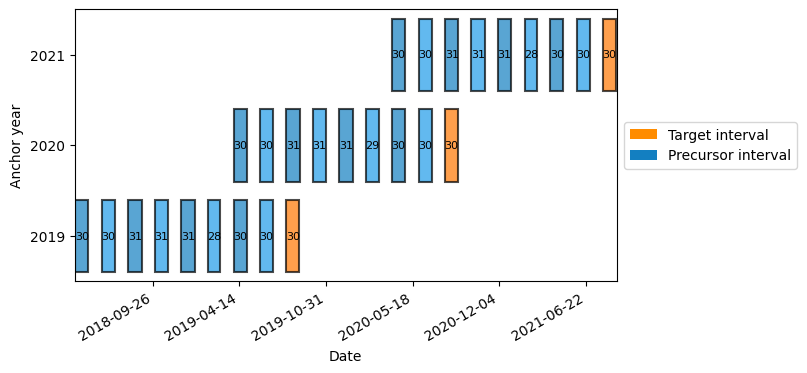

In [8]:
calendar.map_to_data(precursor_field)
calendar.visualize(show_length=True)

In [9]:
def train_test_split(calendar, field):
    """Split data into train and test sets based on calendar intervals."""
    years = sorted(calendar.get_intervals().index)
    start_year = years[0]
    end_year = years[-1]

    # get 70% of instance as training
    train_samples = round(len(years) * 0.7)
    train = field.sel(time=slice(str(start_year), str(start_year + train_samples - 1)))
    test = field.sel(time=slice(str(start_year + train_samples), str(end_year -1)))

    return train, test

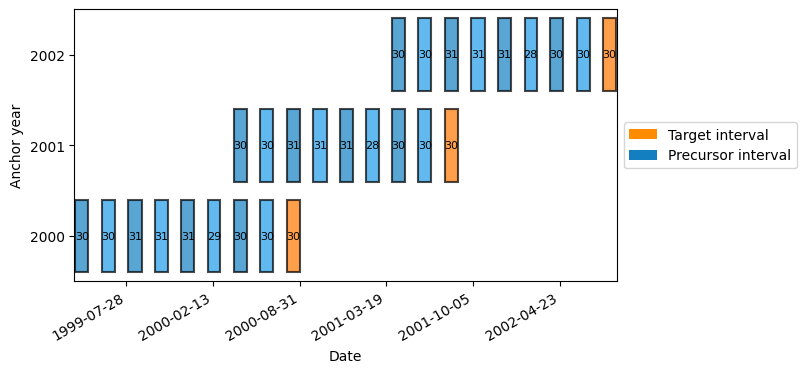

In [10]:
train_slice, test_slice = train_test_split(calendar, precursor_field)
target_train_slice, target_test_slice = train_test_split(calendar, target_field)
calendar.map_to_data(train_slice)
calendar.visualize(show_length=True)

In [11]:
from s2spy import preprocess
from s2spy import RGDR

# create preprocessor
preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    timescale="monthly",
    detrend="linear",
    subtract_climatology=True,
)

# fit preprocessor with training data
preprocessor.fit(train_slice)

/opt/homebrew/Caskroom/miniconda/base/envs/env_tf/lib/python3.9/site-packages/s2spy/preprocess.py:158: UserWarning: The temporal resolution of data does not completely match the target timescale. Please check your input data.
  warnings.warn(


In [12]:
# select variables and intervals
train_prep = preprocessor.transform(train_slice)
precursor_field_resample = lilio.resample(calendar, train_prep)
target_field_resample = lilio.resample(calendar, target_train_slice)

In [13]:
rgdr = RGDR(
    target_intervals=1,
    lag=1,
    eps_km=600,
    alpha=0.05,
    min_area_km2=0)

# Train model on all training data

rgdr.fit(precursor_field_resample, target_field_resample)

# transform to data
clusters = rgdr.transform(precursor_field_resample)

# Prepare test data
calendar.map_to_data(test_slice)
test_prep = preprocessor.transform(test_slice)
precursor_test_resample = lilio.resample(calendar, test_prep)
target_test_resample = lilio.resample(calendar, target_test_slice)

clusters_test = rgdr.transform(precursor_test_resample)

clusters_test

<xarray.DataArray 'data' (anchor_year: 17, i_interval: 1, cluster_labels: 4)> Size: 544B
array([[[ 0.84984631,  0.15386392,  0.02832874, -1.2008396 ]],

       [[-0.2175201 ,  0.46471084,  0.01142347,  0.25819813]],

       [[-0.48630654,  0.35550547,  1.06793638, -0.09396613]],

       [[ 0.00581012, -0.55896247,  0.94164391,  0.61165668]],

       [[ 0.62784   ,  0.35800312,  1.14551882, -0.2005548 ]],

       [[ 1.0515113 ,  1.48581972,  1.02539802, -0.40428868]],

       [[-1.16993814, -0.20151344, -0.08392872,  0.83085988]],

       [[-1.38409534,  0.61204365,  0.07024654,  1.58529556]],

       [[-0.83333175, -0.16906922, -0.16475285,  1.01749021]],

       [[ 1.02709558,  0.86014317,  0.43980083,  0.46346946]],

       [[ 1.3586731 ,  1.34613874,  0.50854823, -0.59299777]],

       [[ 2.22862868,  0.61715229,  0.04581268,  0.52226554]],

       [[ 1.10393265,  0.35315965,  0.30699859,  1.35791681]],

       [[-0.37171664,  0.07155404,  0.39319798,  1.03644611]],

       [[ 0.09147755,  0.25277665, -0.03602316,  0.70783227]],

       [[ 1.10537132,  1.10952415,  0.67234114, -0.05042737]],

       [[ 0.94322166,  1.24624315,  0.38120161,  2.14993948]]])
Coordinates:
  * anchor_year     (anchor_year) int64 136B 2004 2005 2006 ... 2018 2019 2020
  * i_interval      (i_interval) int64 8B -1
    left_bound      (anchor_year, i_interval) datetime64[ns] 136B 2004-06-01 ...
    right_bound     (anchor_year, i_interval) datetime64[ns] 136B 2004-07-01 ...
    is_target       (i_interval) bool 1B False
  * cluster_labels  (cluster_labels) int16 8B -3 -2 -1 1
    latitude        (cluster_labels) float64 32B 40.41 45.39 47.5 27.5
    longitude       (cluster_labels) float64 32B 223.5 200.0 177.5 177.5
Attributes:
    data:         Clustered data with Response Guided Dimensionality Reduction.
    coordinates:  Latitudes and longitudes are geographical centers associate...

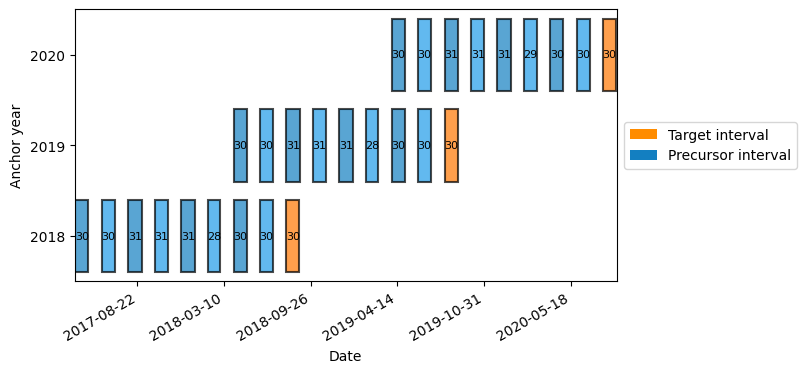

In [14]:
calendar.map_to_data(test_slice)
calendar.visualize(show_length=True)

In [15]:
import onnxruntime as ort
# Load the ONNX model
model_path = 'model.onnx'
session = ort.InferenceSession(model_path)
pred_ort = session.run(None, {"X": clusters_test.isel(i_interval=0).values.astype(np.float32)})[0]

pred_ort

array([[22.099636],
       [23.046902],
       [22.824017],
       [23.1202  ],
       [22.260754],
       [21.736702],
       [23.87988 ],
       [24.014418],
       [23.806273],
       [22.35967 ],
       [21.681746],
       [21.987883],
       [22.8126  ],
       [23.414972],
       [23.136646],
       [22.018574],
       [22.935047]], dtype=float32)

In [16]:
import dianna
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from dianna.utils.onnx_runner import SimpleModelRunner
from dianna.utils.downloader import download

from numba.core.errors import NumbaDeprecationWarning
import warnings
# silence the Numba deprecation warnings in shap
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

def run_model(data):
    # get ONNX predictions
    sess = ort.InferenceSession(model_path)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    onnx_input = {input_name: data.astype(np.float32)}
    pred_onnx = sess.run([output_name], onnx_input)[0]
    
    return pred_onnx

In [17]:
data_instance = clusters_test.isel(i_interval=0).to_numpy()

data_instance[0]

array([ 0.84984631,  0.15386392,  0.02832874, -1.2008396 ])

In [18]:
df = pd.DataFrame(data_instance, columns =['A', 'B', 'C', 'D']) 
df

,A,B,C,D
0,0.849846,0.153864,0.028329,-1.200840
1,-0.217520,0.464711,0.011423,0.258198
2,-0.486307,0.355505,1.067936,-0.093966
3,0.005810,-0.558962,0.941644,0.611657
4,0.627840,0.358003,1.145519,-0.200555
5,1.051511,1.485820,1.025398,-0.404289
6,-1.169938,-0.201513,-0.083929,0.830860
7,-1.384095,0.612044,0.070247,1.585296
8,-0.833332,-0.169069,-0.164753,1.017490
9,1.027096,0.860143,0.439801,0.463469


In [19]:
explanation = dianna.explain_tabular(run_model, input_tabular=data_instance, method='kernelshap',
                                     mode ='regression', training_data = clusters.isel(i_interval=0).values.astype(np.float32), 
                                     training_data_kmeans = 5, feature_names=df.columns)

explanation

  0%|          | 0/17 [00:00<?, ?it/s]

array([[-3.85031602e-01, -4.03375853e-02, -1.52659038e-02,
        -4.46429979e-01],
       [ 9.92923275e-02, -1.18710696e-01, -1.13831134e-02,
         9.10020367e-02],
       [ 2.21256407e-01, -9.11766537e-02, -2.54048030e-01,
        -3.87163011e-02],
       [-2.04453771e-03,  1.39385606e-01, -2.25040765e-01,
         2.21197753e-01],
       [-2.84294851e-01, -9.18065669e-02, -2.71868006e-01,
        -7.79780925e-02],
       [-4.76538454e-01, -3.76159933e-01, -2.44277962e-01,
        -1.53022834e-01],
       [ 5.31458507e-01,  4.92628264e-02,  1.05182406e-02,
         3.01940184e-01],
       [ 6.28633855e-01, -1.55857313e-01, -2.48939272e-02,
         5.79833886e-01],
       [ 3.78721343e-01,  4.10826698e-02,  2.90825859e-02,
         3.70684760e-01],
       [-4.65459381e-01, -2.18409958e-01, -1.09774533e-01,
         1.66613363e-01],
       [-6.15914981e-01, -3.40942383e-01, -1.25565143e-01,
        -2.22533112e-01],
       [-1.01066244e+00, -1.57145152e-01, -1.92815538e-02,
      

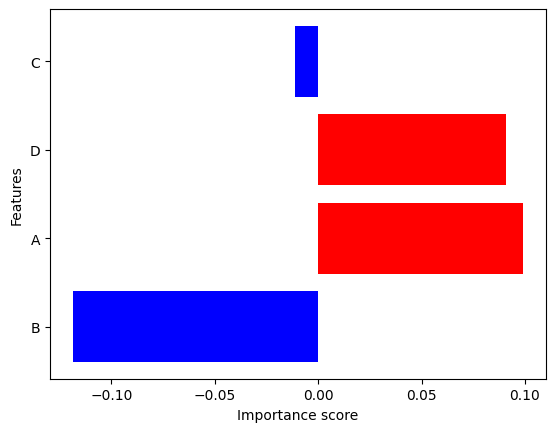

In [20]:
from dianna.visualization import plot_tabular

fig, _ = plot_tabular(explanation[1], df.columns, num_features=4)

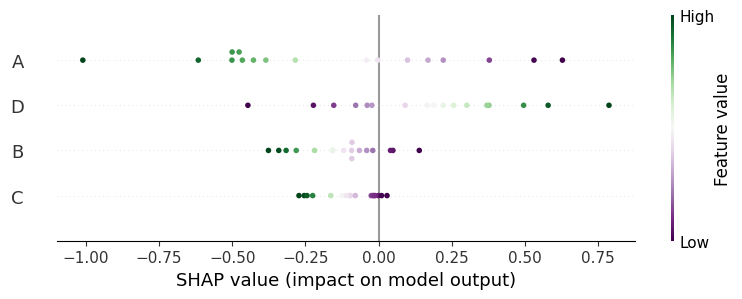

In [21]:
import shap
from shap import Explanation
import matplotlib.pyplot as plt


# create summary plot
shap.summary_plot(explanation, df.values, feature_names=df.columns, cmap="PRGn", show=False, max_display=15)
summary_img = plt.gcf()

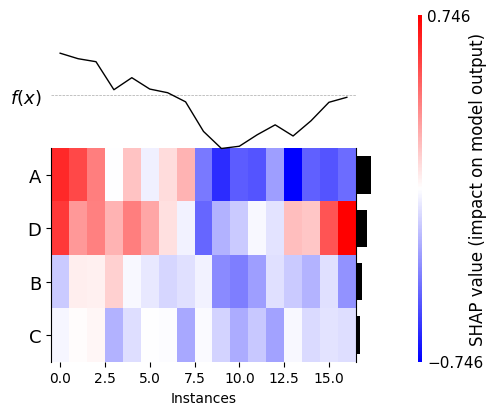

In [22]:
# create heatmap plot
shap_values = Explanation(explanation)
shap_values.feature_names = df.columns

shap.plots.heatmap(shap_values, cmap="bwr", show=False, max_display=15)
heatmap_img = plt.gcf()